In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install geopandas
!pip install basemap

In [3]:
import embedders
import torch

X, y, _ = embedders.dataloaders.load("temperature")
print(X.shape, y.shape)

# Normalize for norm to be 1
X[:, :3] = X[:, :3] / torch.norm(X[:, :3], p=2, dim=1, keepdim=True)

# Permute dimensions

torch.Size([5352, 5]) torch.Size([5352])


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

SEED = 42
MAX_DEPTH = None
N_FEATURES = "d_choose_2"
# N_FEATURES = "d"
USE_SPECIAL_DIMS = False
N_ESTIMATORS = 12

# Set seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# Train model
pm = embedders.manifolds.ProductManifold(signature=[(1, 2), (1, 1)])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_test = y_test.numpy()

# Product DT
pdt = embedders.tree_new.ProductSpaceDT(
# pdt = embedders.tree_new.ProductSpaceRF(
    pm, max_depth=MAX_DEPTH, task="regression", n_features=N_FEATURES, use_special_dims=USE_SPECIAL_DIMS,
    # n_estimators=N_ESTIMATORS
)
pdt.fit(X_train, y_train)
y_pred_pdt = pdt.predict(X_test).flatten().detach().numpy()
pdt_score = np.sqrt(np.mean((y_pred_pdt - y_test) ** 2))
print(f"ProductDT\t{pdt_score:.4f}")

# DT in ambient coords
dt = DecisionTreeRegressor(max_depth=MAX_DEPTH)
# dt = RandomForestRegressor(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
dt.fit(X_train.numpy(), y_train.numpy())
y_pred_dt = dt.predict(X_test.numpy())
dt_score = np.sqrt(np.mean((y_pred_dt - y_test) ** 2))
print(f"Ambient DT\t{dt_score:.4f}")

# DT in tangent plane
X_log_train = pm.logmap(X_train).detach().numpy()
X_log_test = pm.logmap(X_test).detach().numpy()
tdt = DecisionTreeRegressor(max_depth=MAX_DEPTH)
# tdt = RandomForestRegressor(max_depth=MAX_DEPTH, n_estimators=N_ESTIMATORS)
tdt.fit(X_log_train, y_train.numpy())
y_pred_tdt = tdt.predict(X_log_test)
tdt_score = np.sqrt(np.mean((y_pred_tdt - y_test) ** 2))
print(f"TangentDT\t{tdt_score:.4f}")

# k-NN
knn = KNeighborsRegressor()
knn.fit(X_train.numpy(), y_train.numpy())
y_pred_knn = knn.predict(X_test.numpy())
knn_score = np.sqrt(np.mean((y_pred_knn - y_test) ** 2))
print(f"kNeighbors\t{knn_score:.4f}")

ProductDT	2.5990
Ambient DT	2.0591
TangentDT	6.3898
kNeighbors	6.2391


In [53]:
# Look at plots

import embedders.dataloaders


N_POINTS = 400
SHAPE = (N_POINTS + 1, N_POINTS // 2 + 1)


def long_lat_to_xyz(X):
    long, lat = X[:, 0], X[:, 1]
    x = torch.cos(lat) * torch.cos(long)
    y = torch.cos(lat) * torch.sin(long)
    z = torch.sin(lat)
    return torch.stack([x, y, z], dim=1)


def xyz_to_long_lat(X):
    x, y, z = X[:, 0], X[:, 1], X[:, 2]
    long = torch.atan2(y, x)
    lat = torch.asin(z)
    return torch.stack([long, lat], dim=1)


# Get a meshgrid
_x_vals = torch.linspace(-torch.pi, torch.pi, SHAPE[0])
_y_vals = torch.linspace(-torch.pi / 2, torch.pi / 2, SHAPE[1])
_x_vals, _y_vals = torch.meshgrid(_x_vals, _y_vals)
_X = torch.stack([_x_vals.flatten(), _y_vals.flatten()], dim=1)
_X = long_lat_to_xyz(_X)

# Need to add 2 dimensions for month
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Jan")
jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Apr")
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Jul")
# jan_embedding = embedders.dataloaders._month_to_unit_circle_point("Oct")
_X = torch.cat([_X, torch.tensor(jan_embedding).expand(_X.shape[0], -1)], dim=1)

# Transform data to long-lat coords
X_transformed = xyz_to_long_lat(X)

# For plotting, we'll need degrees
_x_vals_degrees = torch.rad2deg(_x_vals).numpy()
_y_vals_degrees = torch.rad2deg(_y_vals).numpy()

In [54]:
# Get predictions

pdt.batched = False
pdt.batch_size = 1
pdt_pred = []
# Predict 100 at a time to avoid memory issues
for i in range(0, len(_X), 100):
    pdt_pred.append(pdt.predict(_X[i:i+100]).numpy())
pdt_pred = np.concatenate(pdt_pred)

/var/folders/ck/0ybgtq694jnd4mbjw_0rm6dh0000gp/T/ipykernel_98747/2783132825.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


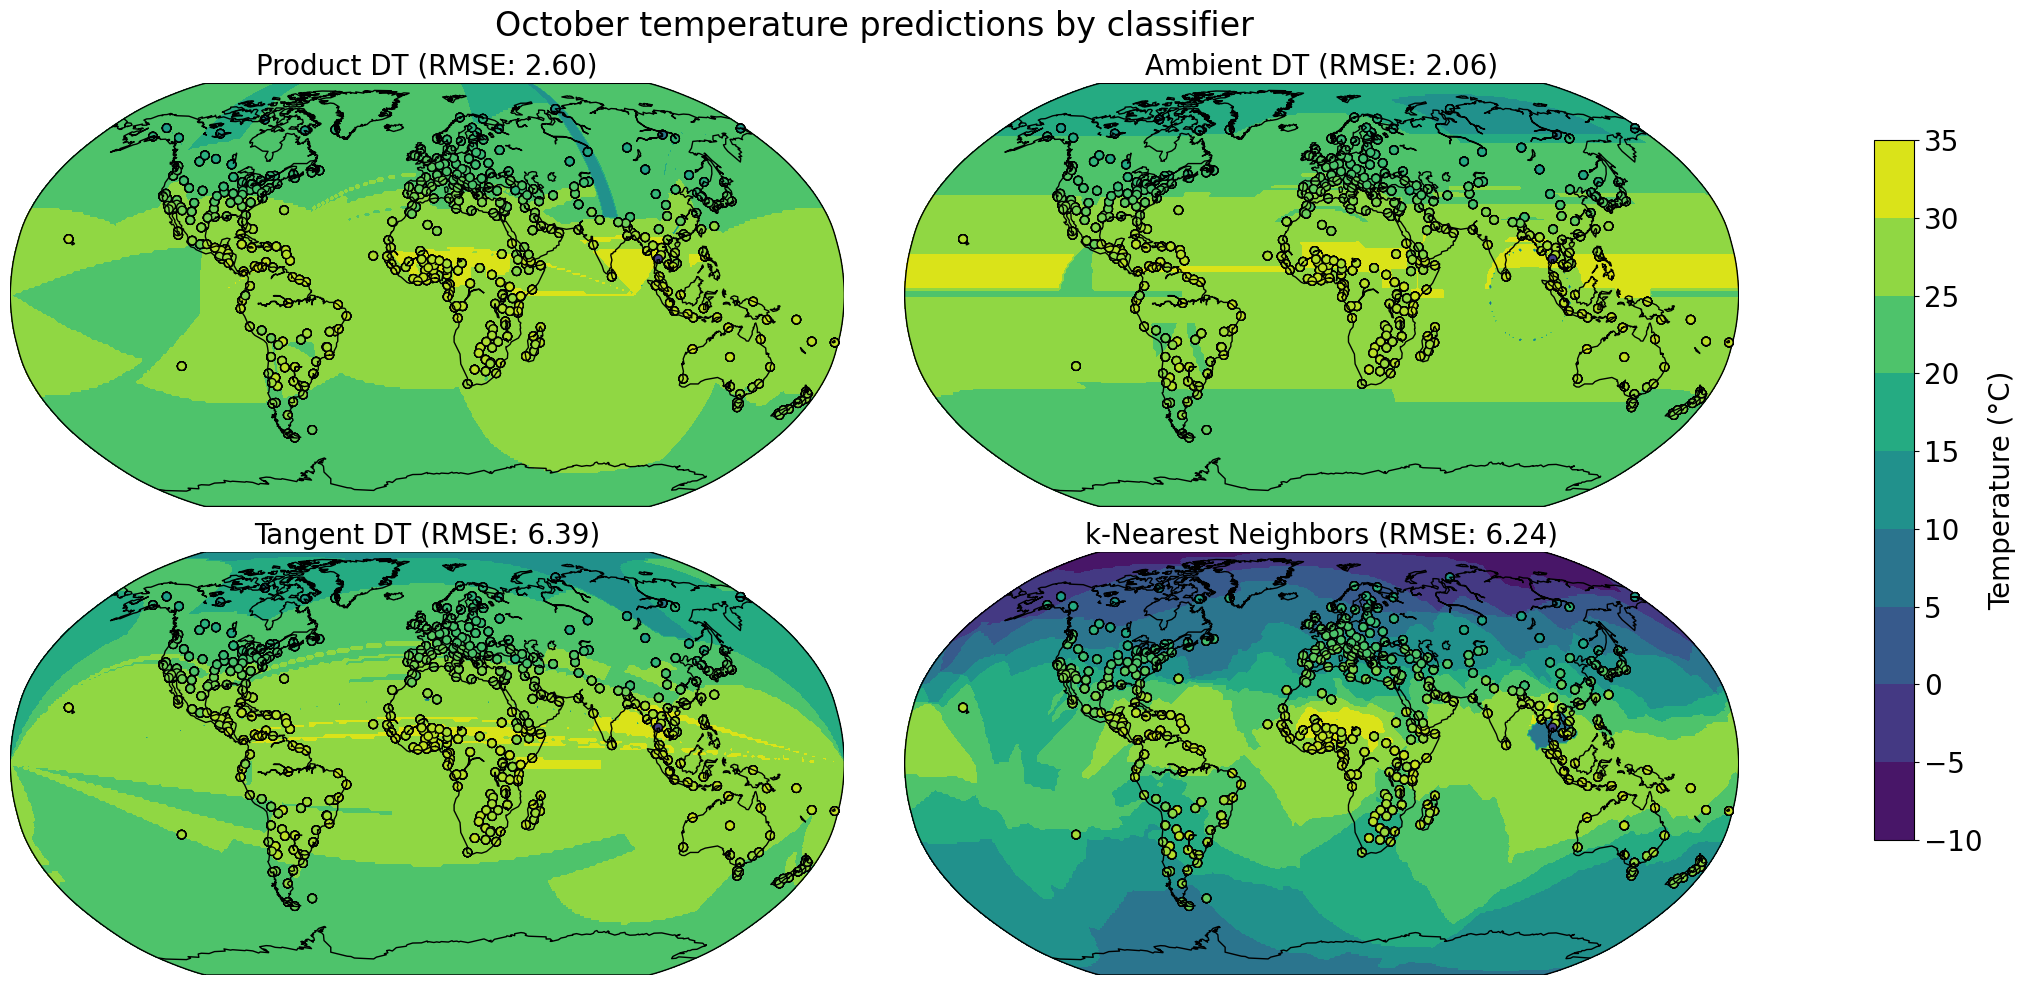

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# LEVELS = 2 ** (MAX_DEPTH) # One for each discrete prediction
LEVELS = None

# Plot surface in long, lat basis
fig, axs = plt.subplots(2, 2, figsize=(20, 10))

# Map
m = Basemap(projection="robin", lon_0=0, resolution="c")
_x_map, _y_map = m(_x_vals_degrees, _y_vals_degrees) # Grid

# Get city coords
city_coords = xyz_to_long_lat(X)
x_map, y_map = m(torch.rad2deg(city_coords[:, 0]).numpy(), torch.rad2deg(city_coords[:, 1]).numpy())

# Plot contours

axs[0, 0].contourf(_x_map, _y_map, pdt_pred.reshape(SHAPE), levels=LEVELS)
axs[0, 0].set_title(f"Product DT (RMSE: {pdt_score:.2f})", fontsize=20)
axs[0, 1].contourf(_x_map, _y_map, dt.predict(_X).reshape(SHAPE), levels=LEVELS)
axs[0, 1].set_title(f"Ambient DT (RMSE: {dt_score:.2f})", fontsize=20)
axs[1, 0].contourf(_x_map, _y_map, tdt.predict(pm.logmap(_X).detach().numpy()).reshape(SHAPE), levels=LEVELS)
axs[1, 0].set_title(f"Tangent DT (RMSE: {tdt_score:.2f})", fontsize=20)
axs[1, 1].contourf(_x_map, _y_map, knn.predict(_X).reshape(SHAPE), levels=LEVELS)
axs[1, 1].set_title(f"k-Nearest Neighbors (RMSE: {knn_score:.2f})", fontsize=20)

for ax in axs.flatten():
    # Ticks off
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("equal")
    m.drawcoastlines(ax=ax)
    ax.scatter(x_map, y_map, c=y, cmap="viridis", edgecolors="black", s=36)

# Colorbar
fig.subplots_adjust(right=1.1)
cbar_ax = fig.add_axes([1.0, 0.15, 0.02, 0.7])
# Colorbar with font size 20
fig.colorbar(axs[1, 1].collections[0], cax=cbar_ax, orientation="vertical", label="Temperature (°C)")
cbar_ax.tick_params(labelsize=20)
# Also the label should be larger
cbar_ax.yaxis.label.set_size(20)

# plt.suptitle("January temperature predictions by classifier", fontsize=24)
# plt.suptitle("April temperature predictions by classifier", fontsize=24)
# plt.suptitle("July temperature predictions by classifier", fontsize=24)
plt.suptitle("October temperature predictions by classifier", fontsize=24)
plt.tight_layout()
# plt.show()
# plt.savefig("../figures/temp_jan.pdf", bbox_inches="tight")
plt.savefig("../figures/temp_apr.pdf", bbox_inches="tight")
# plt.savefig("../figures/temp_jul.pdf", bbox_inches="tight")
# plt.savefig("../figures/temp_oct.pdf", bbox_inches="tight")